In [4]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from PyPDF2 import PdfReader
from pathlib import Path
import os

/Users/omerfaruk/anaconda3/envs/ba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Loading the spaCy model for English
nlp = spacy.load('en_core_web_sm')

# Pre-processing function using spaCy
def preprocess_text(text):
    doc = nlp(text)
    # Tokenize, remove stop words, punctuation, and lemmatize
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

In [6]:
def convert_pdf_to_text(pdf_file):
    with open(pdf_file, 'rb') as file:
        pdf_reader = PdfReader(file)

        text = ""
        num_pages = len(pdf_reader.pages)

        for page_num in range(num_pages):
            page = pdf_reader.pages[page_num]
            text += page.extract_text()

    return text

In [7]:
# Function to gather PDF files from a directory
def get_pdf_files_from_directory(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.pdf')]

In [8]:
# List of models to compare
model_ids = ["all-MiniLM-L6-v2", "all-MiniLM-L12-v2", "all-mpnet-base-v2", "all-distilroberta-v1"]

In [9]:
directories = ['/Users/omerfaruk/Bachelorarbeit/LLM_omer/pdf_documents/MI',
               '/Users/omerfaruk/Bachelorarbeit/LLM_omer/pdf_documents/AA',
               '/Users/omerfaruk/Bachelorarbeit/LLM_omer/pdf_documents/IEA']

# Gather PDF files for each topic (MI, AA, IEA)
mi = get_pdf_files_from_directory(directories[0])
aa = get_pdf_files_from_directory(directories[1])
iea = get_pdf_files_from_directory(directories[2])

# Convert PDFs to text and preprocess the text for each topic
topics_documents = {
    'topic1': [preprocess_text(convert_pdf_to_text(pdf)) for pdf in mi],
    'topic2': [preprocess_text(convert_pdf_to_text(pdf)) for pdf in aa],
    'topic3': [preprocess_text(convert_pdf_to_text(pdf)) for pdf in iea],
}

# Print the results
print(topics_documents)

{'topic1': ['Multi Class Classification Motor Imagery EEG \n signal image base Deep Recurrent \n Convolutional Neural Network \n \n Ward Fadel1 2 Csaba Kollod1 2 Moutz Wahdow1 2 Yahya Ibrahim1 Istvan Ulbert1 2 \n 1 Faculty Information Technology Bionics Pazmany Peter Catholic University Budapest Hungary  \n 2 Institute Cognitive Neuroscience psychology Research Centre Natural Sciences Budapest Hungary \n fadel.ward kollod.csaba wahdow.moutz ibrahim.yahya ulbert.istvan}@itk.ppke.hu \n \n \n abstract Classification EEG signal cornerstone \n build motor imagery MI base Brain computer interface \n BCI system eeg signal diff er subject \n subject different trial design general classification model debate deep learning dominant field like computer vision natural language processing investigation \n EEG signal classification follow new trend EEG signal classification th ese signal transform \n image classify signal image classification problem Deep learning work Physionet dataset EEG motor mo

In [11]:
# Function to calculate similarity matrix using internal similarity operations
def calculate_similarity_matrix(model, topics_documents, similarity_function):
    topics = list(topics_documents.keys())
    documents = [doc for docs in topics_documents.values() for doc in docs]
    embeddings = model.encode(documents)
    
    similarity_matrix = np.zeros((len(topics), len(topics)))

    for i, topic1 in enumerate(topics):
        for j, topic2 in enumerate(topics):
            # Select the corresponding embeddings for each topic
            embeddings1 = embeddings[i*len(topics_documents[topic1]):(i+1)*len(topics_documents[topic1])]
            embeddings2 = embeddings[j*len(topics_documents[topic2]):(j+1)*len(topics_documents[topic2])]

            # Calculate similarity using the specified function
            similarity = similarity_function(embeddings1, embeddings2)  # <-- This is the line
            similarity_matrix[i, j] = similarity.mean().item()

    return similarity_matrix

In [12]:
# Compare the similarity functions for each model
similarity_functions = {
    "cosine": util.pytorch_cos_sim,
    "dot": lambda x, y: np.dot(x, y.T),
    # For Euclidean distance
    "euclidean": lambda x, y: np.linalg.norm(x[:, None, :] - y[None, :, :], axis=2),
    # For Manhattan distance
    "manhattan": lambda x, y: np.sum(np.abs(x[:, None, :] - y[None, :, :]), axis=2)
}

In [13]:
# Ranking criteria function
def rank_matrix(matrix):
    score = 0
    # Criteria 1: Highest diagonal cells
    diagonal_cells = [matrix[0, 0], matrix[1, 1], matrix[2, 2]]
    max_diagonal = all(diag >= max(matrix[i, j] for i in range(3) for j in range(3) if i != j) for diag in diagonal_cells)
    if max_diagonal:
        score += 1  # Pass criterion 1
    
    # Criteria 2: Off-diagonal cells should not exceed diagonal cells
    off_diagonal_cells = [matrix[0, 1], matrix[0, 2], matrix[1, 0], matrix[1, 2], matrix[2, 0], matrix[2, 1]]
    if all(off <= min(diagonal_cells) for off in off_diagonal_cells):
        score += 1  # Pass criterion 2

    # Criteria 3: [1,2] and [2,1] should have second-highest values after diagonals
    sorted_values = sorted(matrix.ravel(), reverse=True)
    if matrix[1, 2] in sorted_values[3:5] and matrix[2, 1] in sorted_values[3:5]:
        score += 1  # Pass criterion 3
    
    # Criteria 4: [2,0] and [0,2] should have third-highest values after [1,2] and [2,1]
    if matrix[2, 0] in sorted_values[5:7] and matrix[0, 2] in sorted_values[5:7]:
        score += 1  # Pass criterion 4

    return score

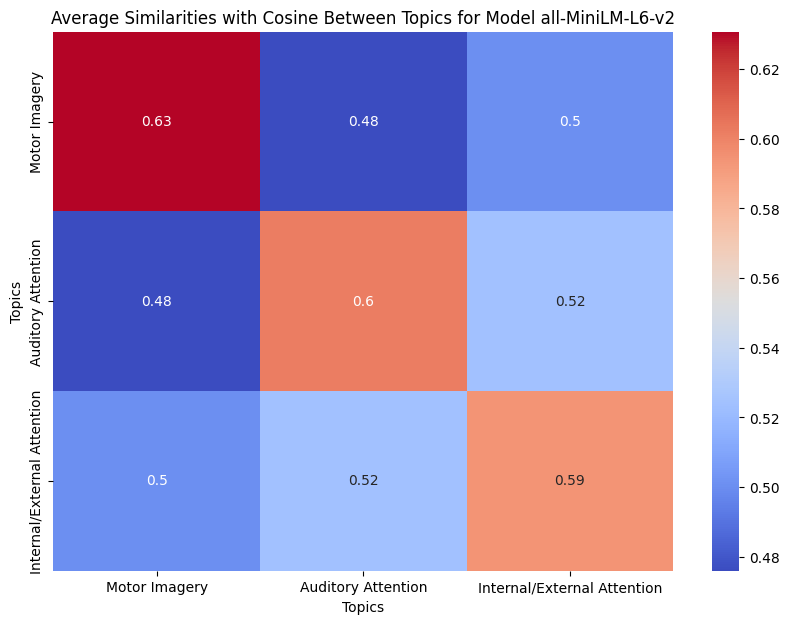

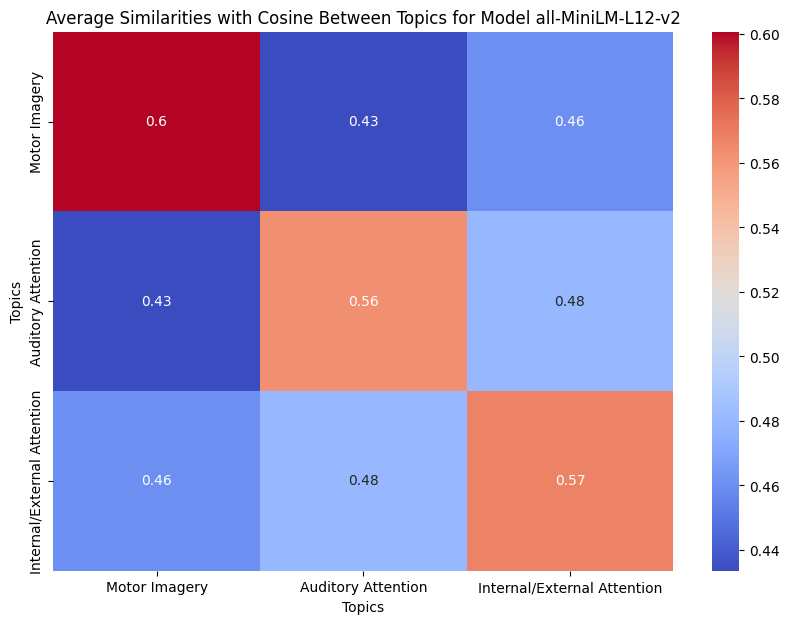

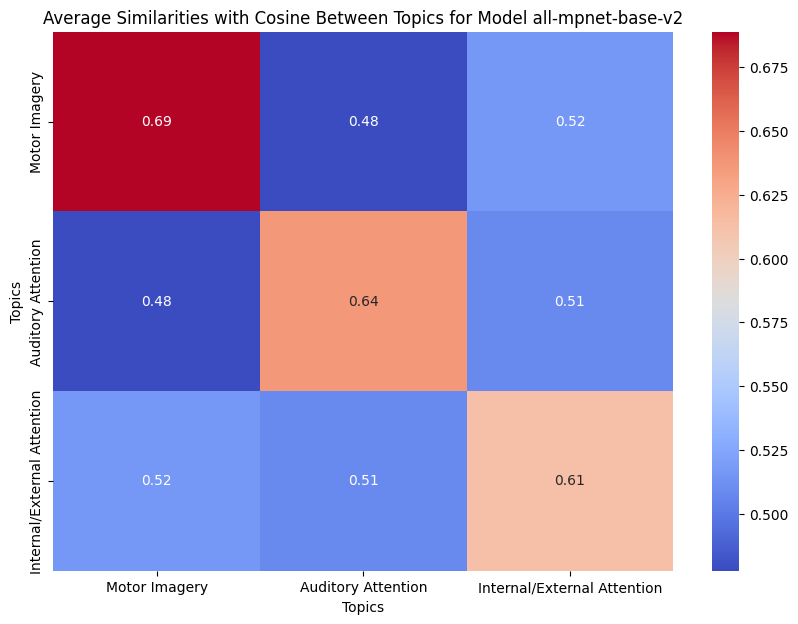

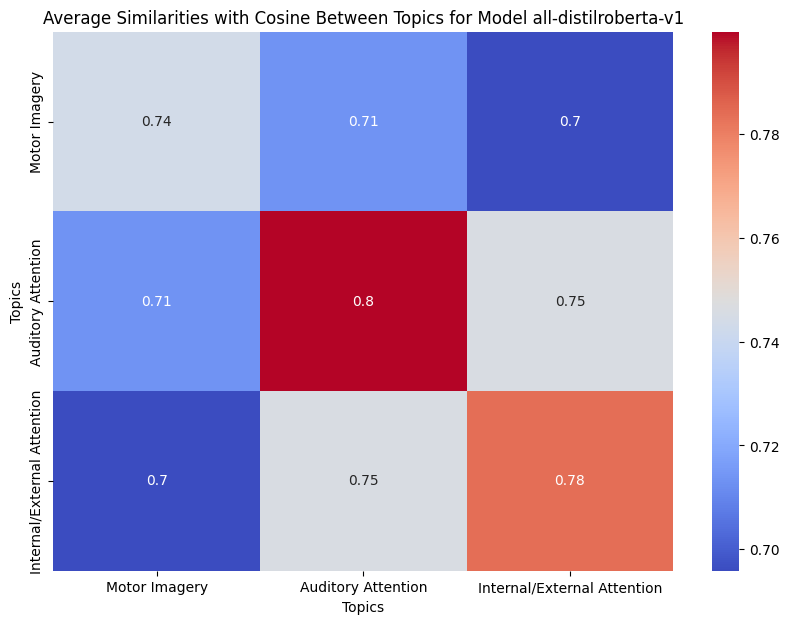

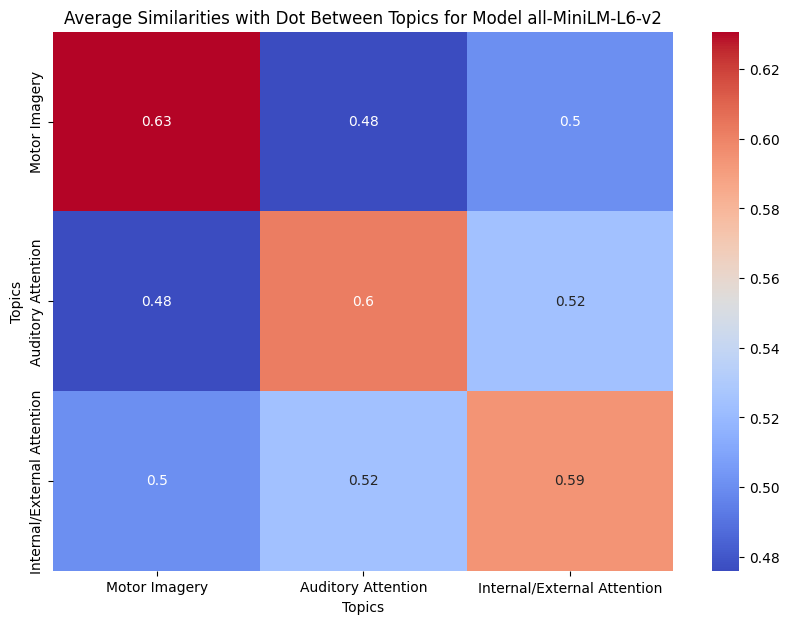

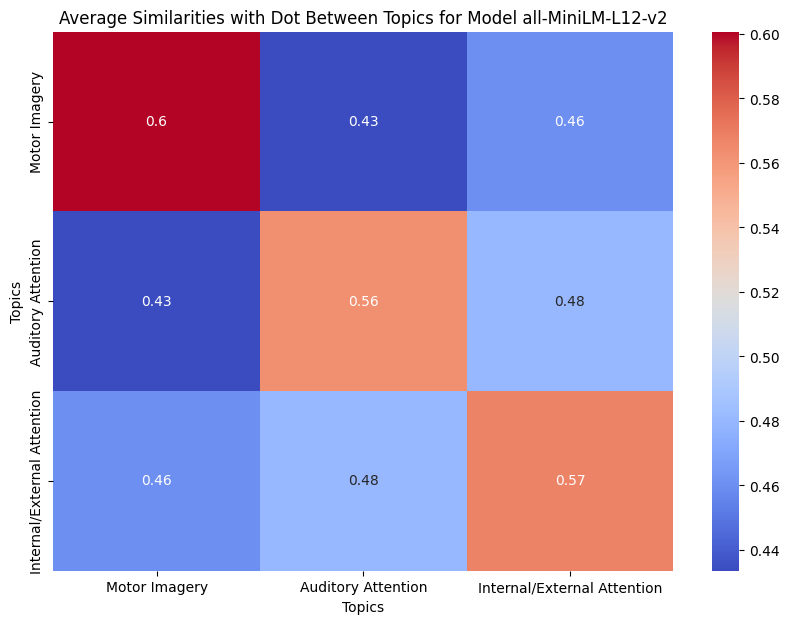

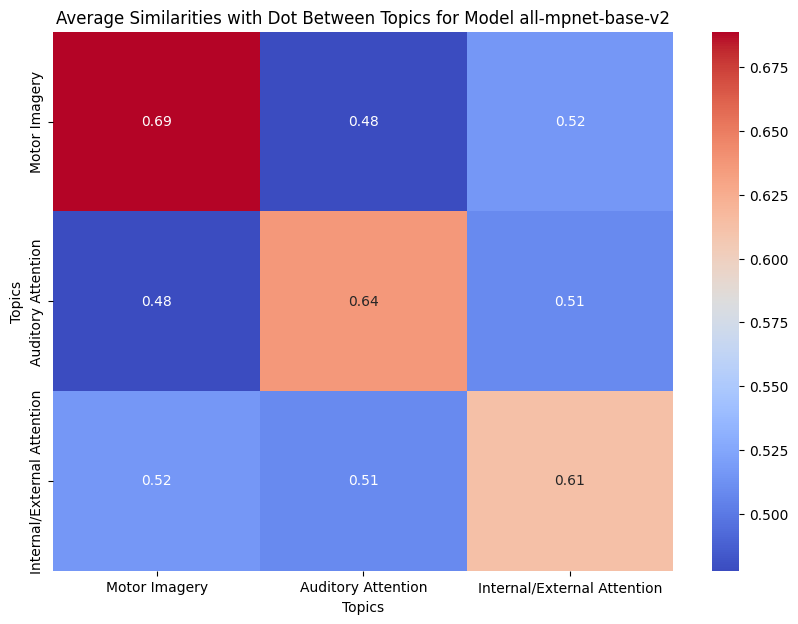

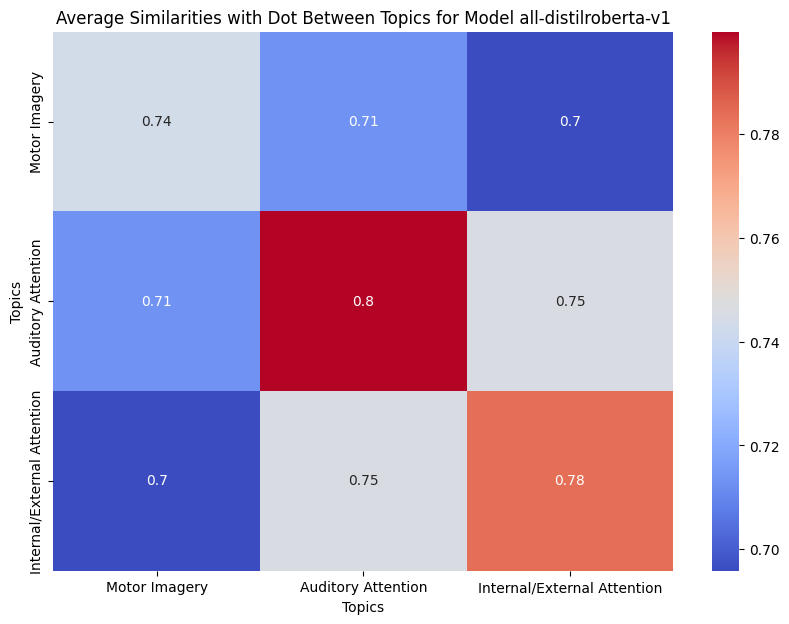

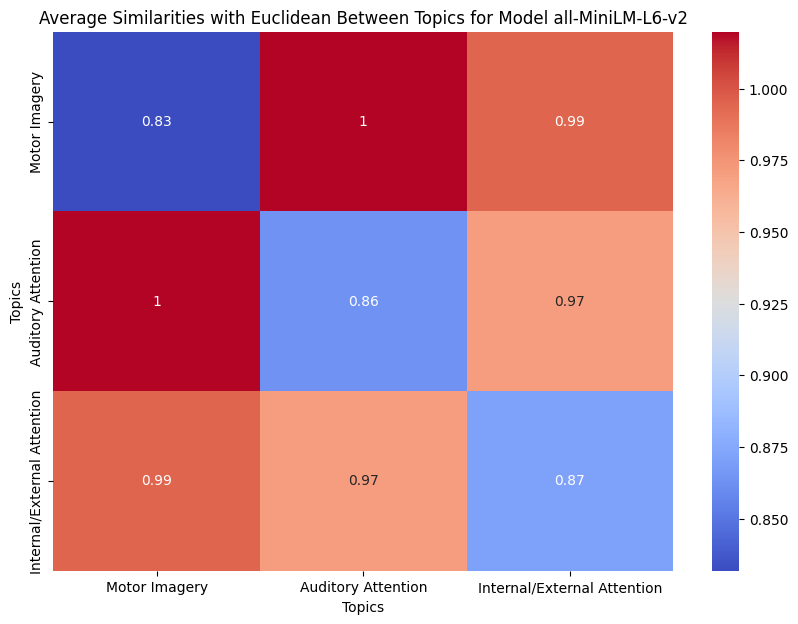

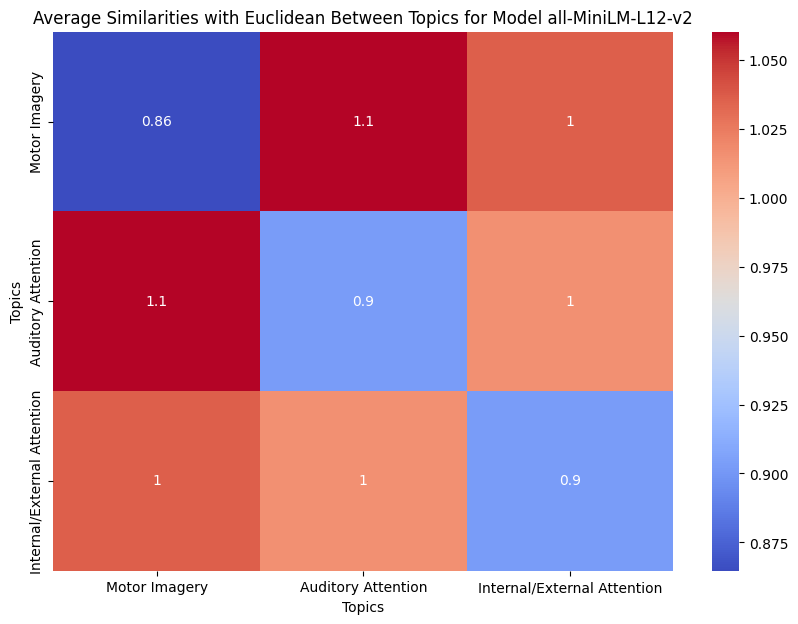

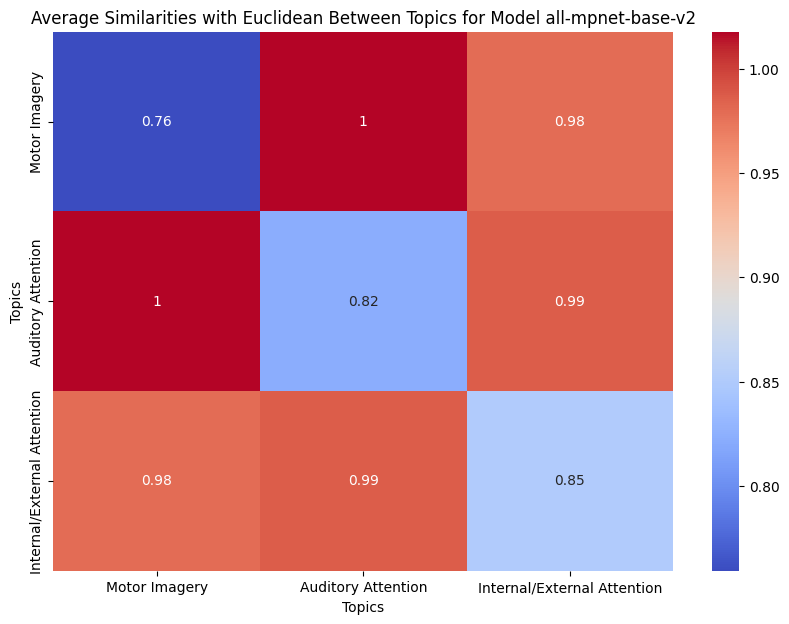

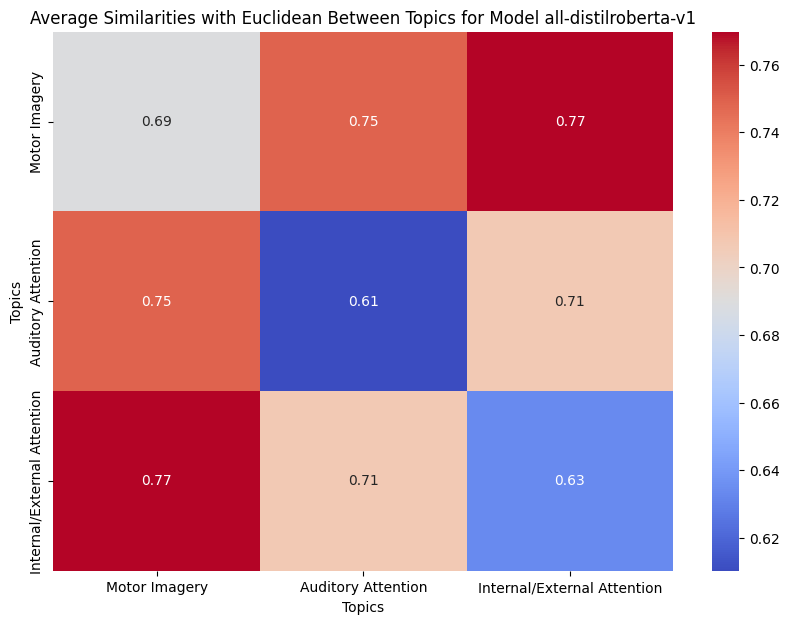

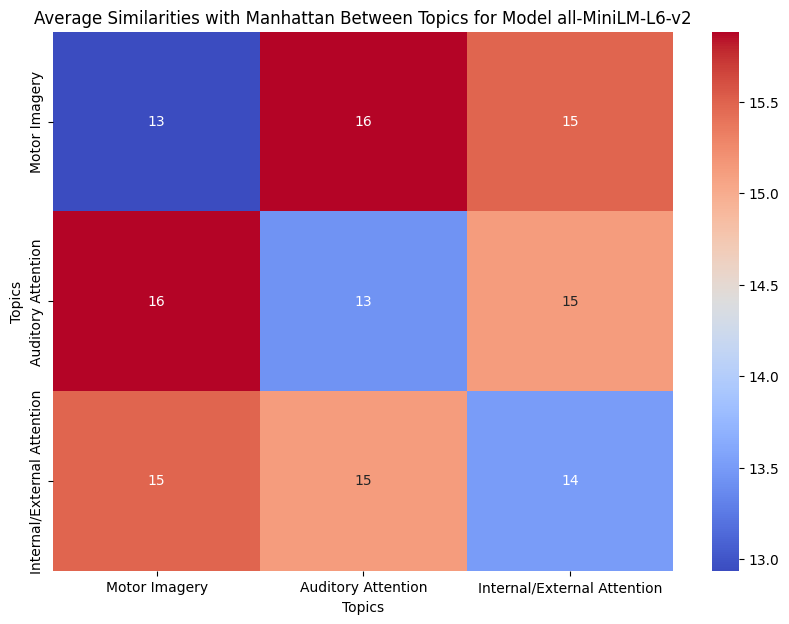

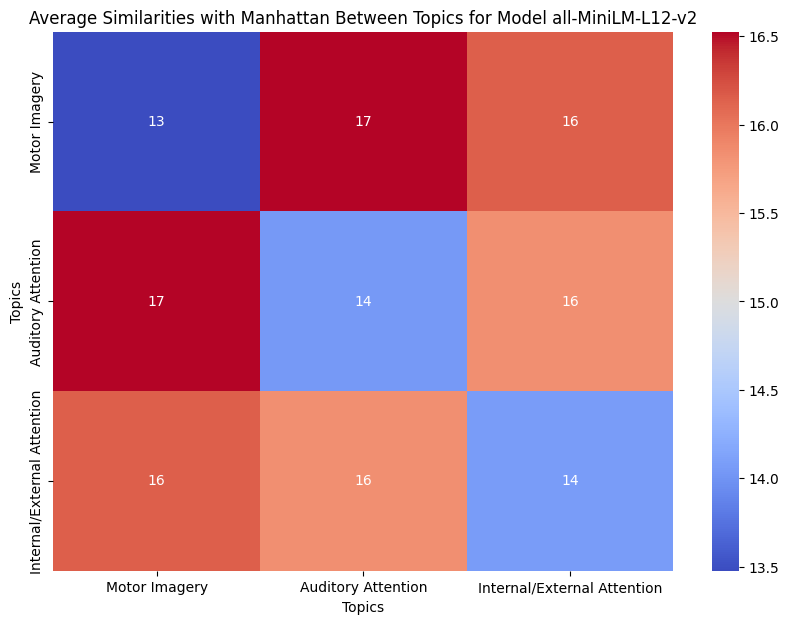

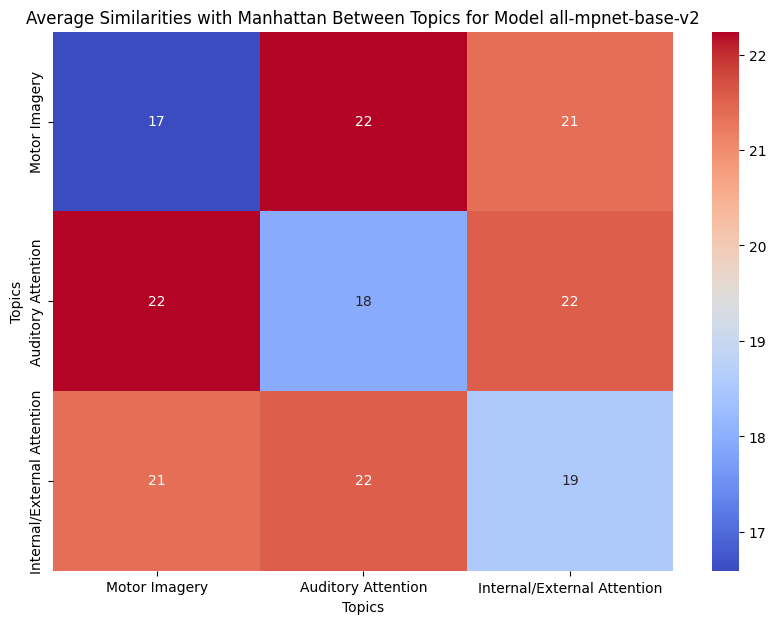

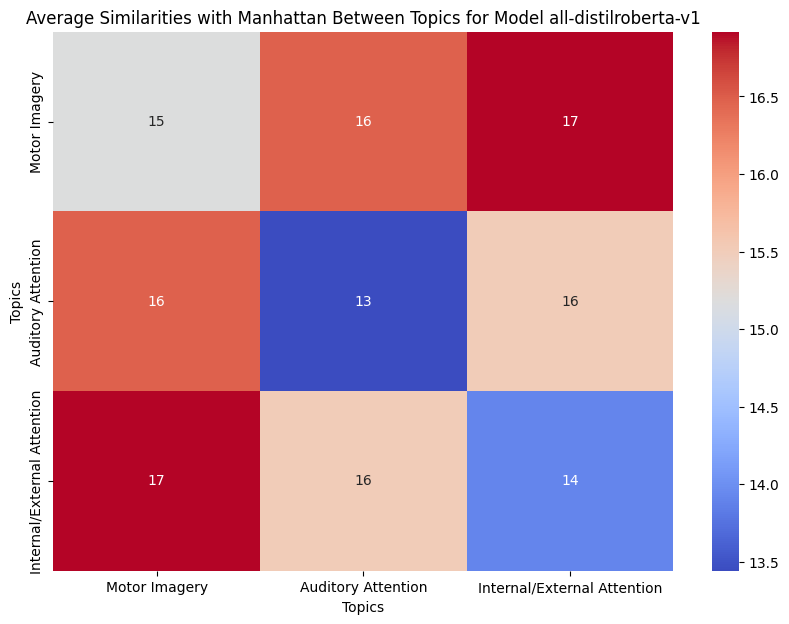

In [14]:
# Similarity matrices for all models and similarity functions
all_similarity_matrices = {}  # Collect matrices for all models and similarity functions

for similarity_function_name, similarity_function in similarity_functions.items():

    for model_id in model_ids:
        model = SentenceTransformer(model_id)
        # Calculating similarity matrix for each model with each similarity function
        similarity_matrix = calculate_similarity_matrix(model, topics_documents, similarity_function)
        # Unique key for each model-function combination
        all_similarity_matrices[f"{model_id}_{similarity_function_name}"] = similarity_matrix

        # Plot the similarity matrix
        subjects = ["Motor Imagery", "Auditory Attention", "Internal/External Attention"]
        plt.figure(figsize=(10, 7))
        sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=subjects, yticklabels=subjects)
        plt.xlabel('Topics')
        plt.ylabel('Topics')
        plt.title(f'Average Similarities with {similarity_function_name.title()} Between Topics for Model {model_id}')
        plt.show()

In [16]:
# Apply the ranking function to each matrix
rankings = {name: rank_matrix(matrix) for name, matrix in all_similarity_matrices.items()}
sorted_rankings = sorted(rankings.items(), key=lambda x: x[1], reverse=True)
print(sorted_rankings)

[('all-MiniLM-L6-v2_cosine', 4), ('all-MiniLM-L12-v2_cosine', 4), ('all-MiniLM-L6-v2_dot', 4), ('all-MiniLM-L12-v2_dot', 4), ('all-mpnet-base-v2_cosine', 2), ('all-mpnet-base-v2_dot', 2), ('all-mpnet-base-v2_euclidean', 2), ('all-distilroberta-v1_cosine', 1), ('all-distilroberta-v1_dot', 1), ('all-MiniLM-L6-v2_euclidean', 1), ('all-MiniLM-L12-v2_euclidean', 1), ('all-distilroberta-v1_euclidean', 1), ('all-MiniLM-L6-v2_manhattan', 1), ('all-MiniLM-L12-v2_manhattan', 1), ('all-mpnet-base-v2_manhattan', 1), ('all-distilroberta-v1_manhattan', 0)]


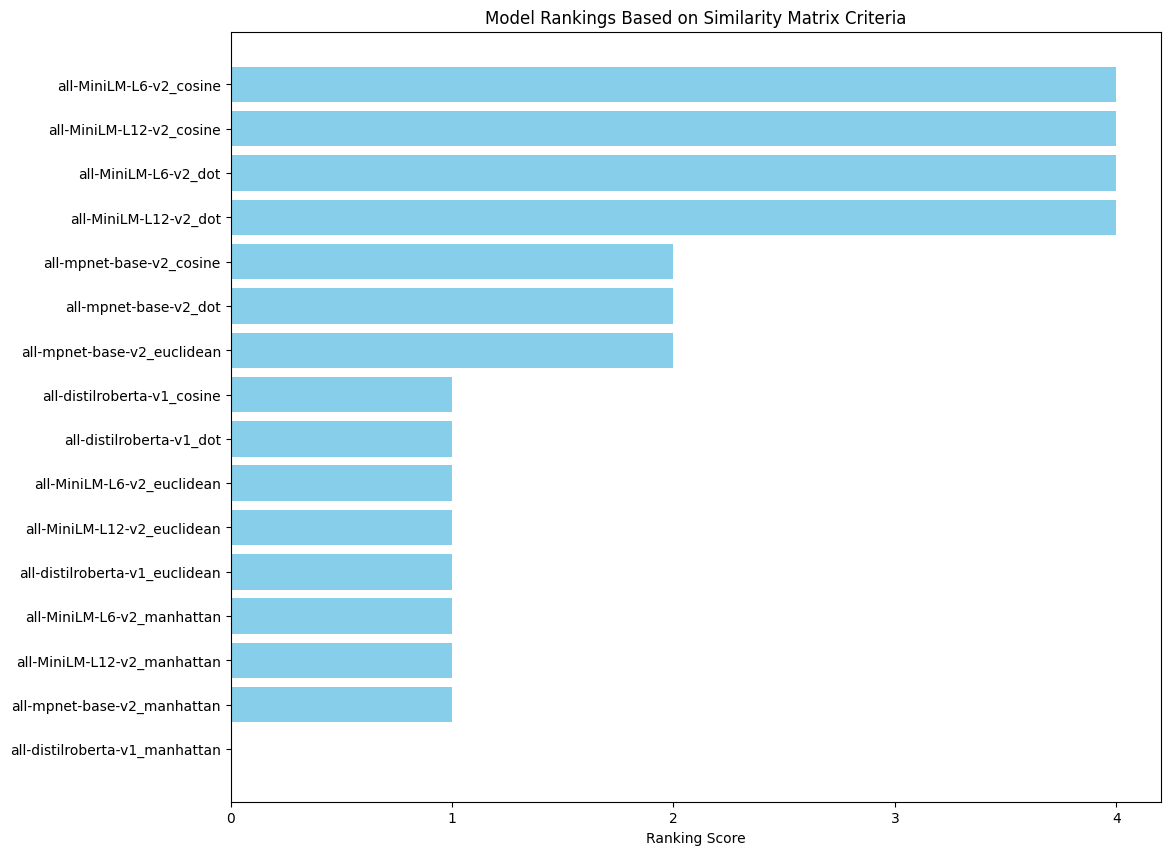

In [42]:
model_names, scores = zip(*sorted_rankings)

# Plotting the ranking of models
plt.figure(figsize=(12, 10))
plt.barh(model_names, scores, color='skyblue')
plt.xlabel('Ranking Score')
plt.title('Model Rankings Based on Similarity Matrix Criteria')
plt.gca().invert_yaxis()  # Invert y-axis to show highest rank at the top
plt.xticks(range(int(min(scores)), int(max(scores)) + 1))
plt.show()

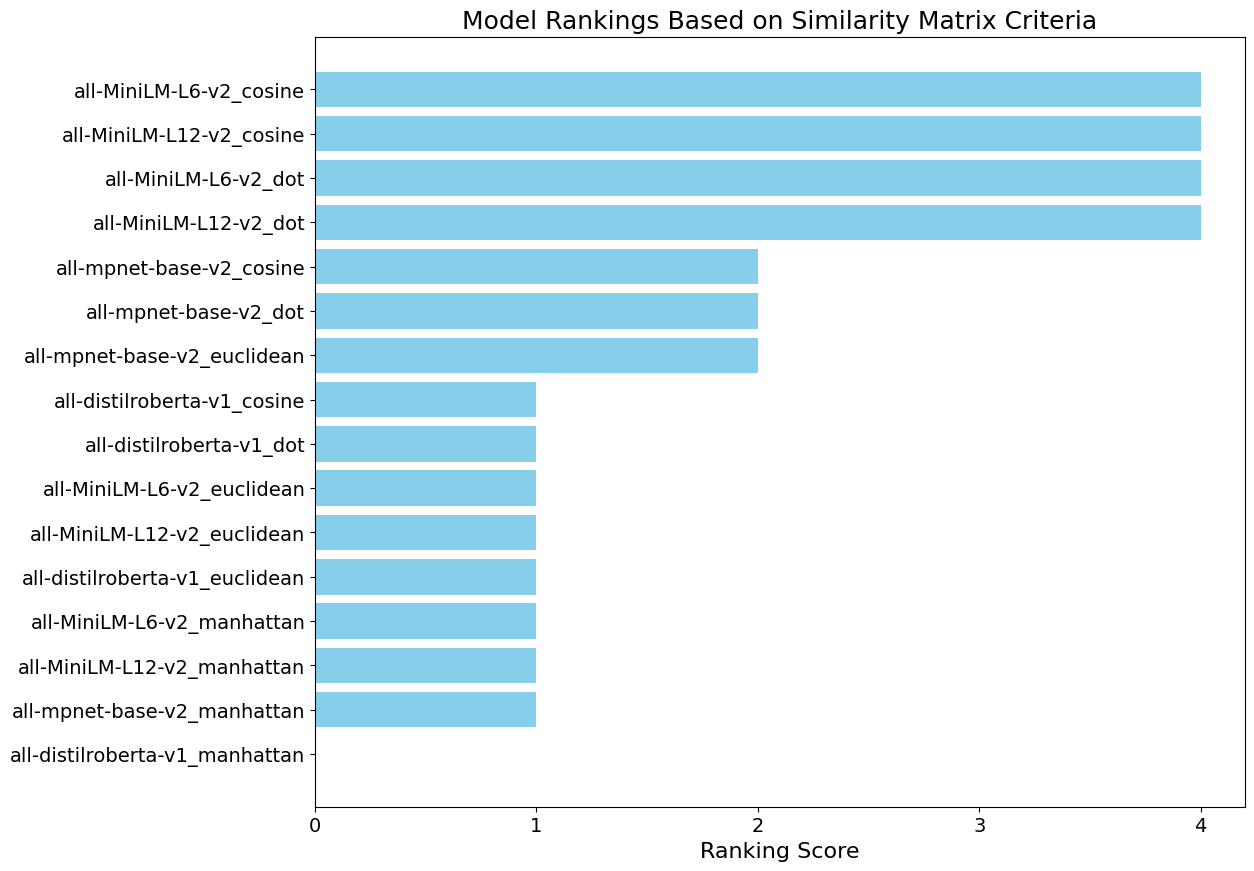

In [52]:
# Separate model names and scores
model_names, scores = zip(*sorted_rankings)

# Plotting the ranking of models
plt.figure(figsize=(12, 10))
plt.barh(model_names, scores, color='skyblue')
plt.xlabel('Ranking Score', fontsize=16)
plt.title('Model Rankings Based on Similarity Matrix Criteria', fontsize=18)
plt.gca().invert_yaxis()  # Invert y-axis to show highest rank at the top
plt.xticks(range(int(min(scores)), int(max(scores)) + 1), fontsize=14)
# Set font size for model names
plt.yticks(fontsize=14)  # Adjust fontsize as desired
plt.show()


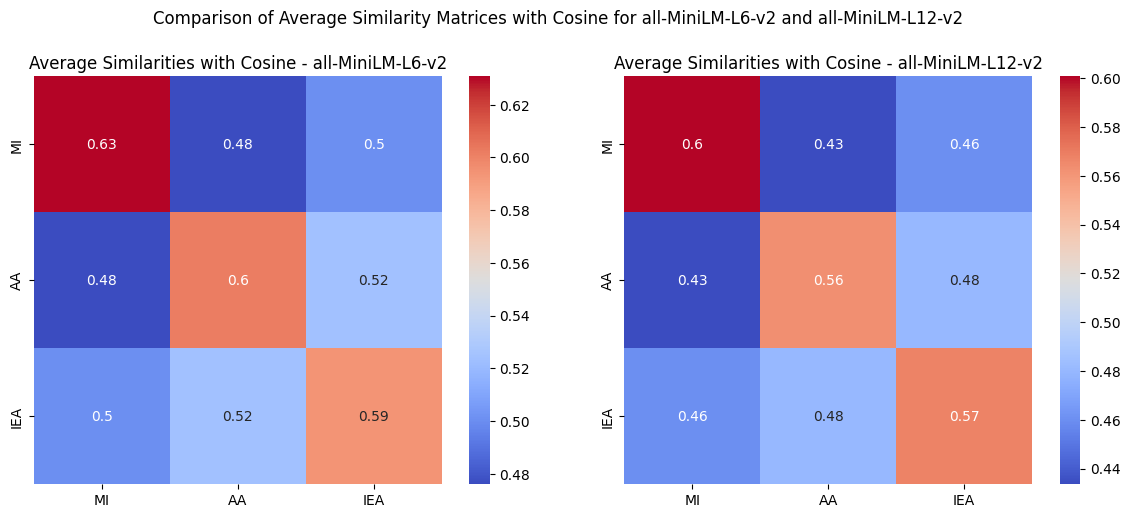

In [34]:
# Assuming these matrices are 3x3 for simplicity
all_MiniLM_L6_v2_cosine = np.array([
    [0.63075656, 0.47597444, 0.50073165],
    [0.47597444, 0.60193682, 0.52398843],
    [0.50073165, 0.52398849, 0.59429568]
])

all_MiniLM_L12_v2_cosine = np.array([
    [0.60070735, 0.43354461, 0.4599148],
    [0.43354461, 0.56320304, 0.48002988],
    [0.4599148, 0.48002991, 0.56740552]
])

topics = ["MI", "AA", "IEA"]

# Plot the two matrices side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for all-MiniLM-L6-v2 cosine similarity matrix
sns.heatmap(all_MiniLM_L6_v2_cosine, annot=True, cmap='coolwarm', ax=axes[0], cbar=True, square=True)
axes[0].set_title('Average Similarities with Cosine - all-MiniLM-L6-v2')
axes[0].set_xticklabels(topics)
axes[0].set_yticklabels(topics)

# Plot for all-MiniLM-L12-v2 cosine similarity matrix
sns.heatmap(all_MiniLM_L12_v2_cosine, annot=True, cmap='coolwarm', ax=axes[1], cbar=True, square=True)
axes[1].set_title('Average Similarities with Cosine - all-MiniLM-L12-v2')
axes[1].set_xticklabels(topics)
axes[1].set_yticklabels(topics)

# Display the plot
plt.suptitle('Comparison of Average Similarity Matrices with Cosine for all-MiniLM-L6-v2 and all-MiniLM-L12-v2')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [30]:
all_similarity_matrices['all-MiniLM-L6-v2_cosine']

array([[0.63075656, 0.47597444, 0.50073165],
       [0.47597444, 0.60193682, 0.52398843],
       [0.50073165, 0.52398849, 0.59429568]])

In [31]:
all_similarity_matrices['all-MiniLM-L6-v2_dot']

array([[0.63075656, 0.47597438, 0.50073165],
       [0.47597444, 0.60193682, 0.52398843],
       [0.50073165, 0.52398843, 0.59429568]])

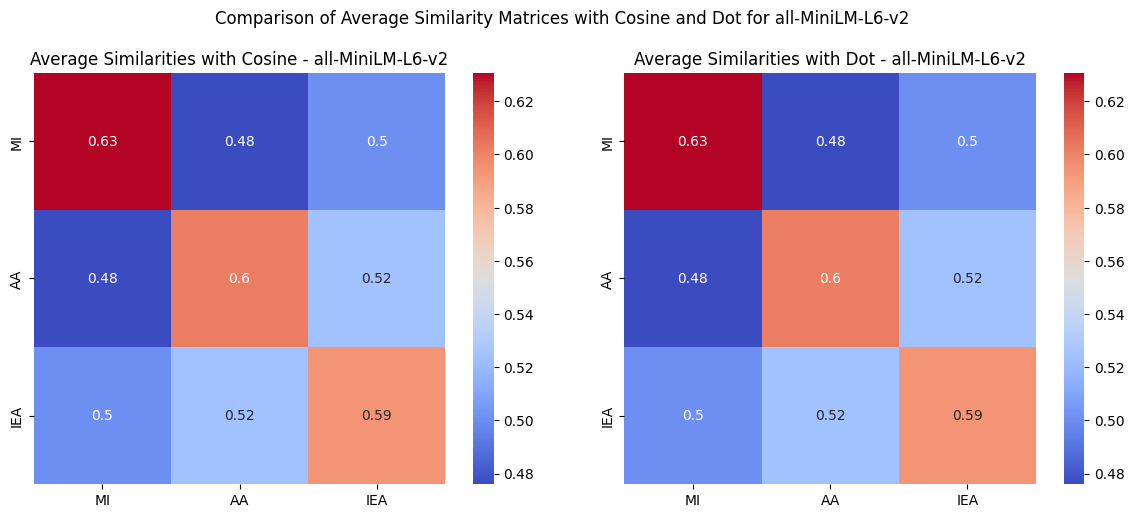

In [35]:
# Plot the two matrices side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for all-MiniLM-L6-v2 cosine similarity matrix
sns.heatmap(all_similarity_matrices['all-MiniLM-L6-v2_cosine'], annot=True, cmap='coolwarm', ax=axes[0], cbar=True, square=True)
axes[0].set_title('Average Similarities with Cosine - all-MiniLM-L6-v2')
axes[0].set_xticklabels(topics)
axes[0].set_yticklabels(topics)

# Plot for all-MiniLM-L12-v2 cosine similarity matrix
sns.heatmap(all_similarity_matrices['all-MiniLM-L6-v2_dot'], annot=True, cmap='coolwarm', ax=axes[1], cbar=True, square=True)
axes[1].set_title('Average Similarities with Dot - all-MiniLM-L6-v2')
axes[1].set_xticklabels(topics)
axes[1].set_yticklabels(topics)

# Display the plot
plt.suptitle('Comparison of Average Similarity Matrices with Cosine and Dot for all-MiniLM-L6-v2')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()